# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Team:** Group 5  
**Authors:** Chun-Hung Yeh, Kuan Tung, Zhuoyue Wang  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Import required packages

In [1]:
import tarfile
import os

import cv2 as cv
import numpy as np
import skimage.io
from skimage import measure, transform, morphology
import matplotlib.pyplot as plt
%matplotlib inline

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

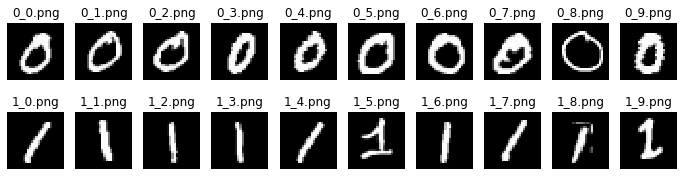

In [3]:
# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

In [4]:
def preprocessing(im):
    """Preprocessing on the image to get a better contour."""
    # binarize the image with an automatically computed threshold
    _, im = cv.threshold(im, 0, 1, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # remove small noises by morphology
    im = morphology.remove_small_objects(im.astype(bool), min_size=10)
    return im

In [5]:
def find_contour(im):
    """Find the longest contour in the image."""
    # find contours and pick the longest contour
    contours = sorted(measure.find_contours(im, 0), key=lambda c: c.shape[0], reverse=True)
    contour = contours[0]
    return contour

In [6]:
def compute_fourier_descriptors(im):
    """Compute 2-dimensional Fourier descriptors."""
    im = preprocessing(im)
    contour = find_contour(im)
    points = contour[:, 1] + 1j * contour[:, 0]
    descriptors = np.fft.fft(points)
    # normalize the third and forth coefficients by the second one
    features = abs(descriptors[2:4]) / abs(descriptors[1])
    return features

In [25]:
def plot_2d_graph_without_transform(feat_func, im_1, im_2, label_1, label_2, xlabel, ylabel):
    """Plot features on a 2D graph wihtout applying any transformation."""
    zeros_feat = np.array(list(map(feat_func, im_1)))
    ones_feat = np.array(list(map(feat_func, im_2)))
    plt.scatter(zeros_feat[:, 0], zeros_feat[:, 1], label=label_1)
    plt.scatter(ones_feat[:, 0], ones_feat[:, 1], label=label_2)
    plt.legend(loc='best')
    plt.title('Visualize Fourier descriptors without any transformation')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

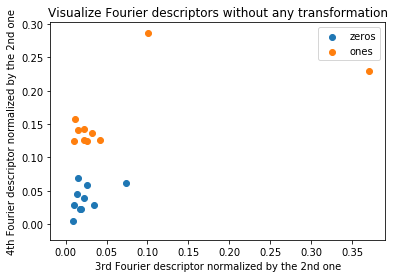

In [26]:
plot_2d_graph_without_transform(
    compute_fourier_descriptors,
    zeros_im, ones_im,
    'zeros', 'ones',
    xlabel='3rd Fourier descriptor normalized by the 2nd one',
    ylabel='4th Fourier descriptor normalized by the 2nd one'
)

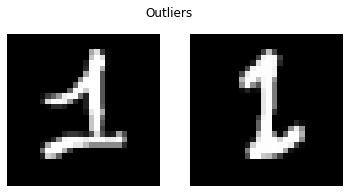

In [9]:
# check the outliers
ones_feat = np.array(list(map(compute_fourier_descriptors, ones_im)))
outliers = ones_im[ones_feat[:, 1] > 0.2]
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle('Outliers')
for i in range(2):
    axes[i].imshow(outliers[i], cmap='gray')
    axes[i].axis('off')

In [10]:
def custom_rescale(im, scale):
    """Custom rescale function which preserves original shape."""
    output = np.zeros_like(im, dtype='uint8')
    rescaled = transform.rescale(im, scale, preserve_range=True, multichannel=False)
    new_dim = rescaled.shape[0]
    start_dim = int(im.shape[0] / 2 * scale)
    output[start_dim:start_dim + new_dim, start_dim:start_dim + new_dim] = rescaled
    return output

In [11]:
# apply transformation
# translation
translation_transform = transform.AffineTransform(translation=(2, -2))
translated_zeros_im = np.array(list(map(lambda im: transform.warp(im, translation_transform, preserve_range=True), zeros_im)), dtype='uint8')
translated_ones_im = np.array(list(map(lambda im: transform.warp(im, translation_transform, preserve_range=True), ones_im)), dtype='uint8')
# rotation
rotated_zeros_im = np.array(list(map(lambda im: transform.rotate(im, 90, order=5, preserve_range=True), zeros_im)), dtype='uint8')
rotated_ones_im = np.array(list(map(lambda im: transform.rotate(im, 90, order=5, preserve_range=True), ones_im)), dtype='uint8')
# scaling
scaled_zeros_im = np.array(list(map(lambda im: custom_rescale(im, 0.5), zeros_im)), dtype='uint8')
scaled_ones_im = np.array(list(map(lambda im: custom_rescale(im, 0.5), ones_im)), dtype='uint8')

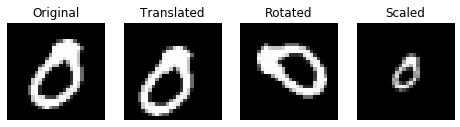

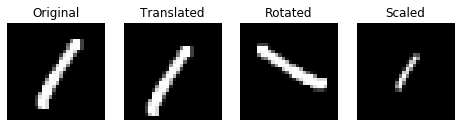

In [12]:
# show example images after the transformation
plot_name = ['Original', 'Translated', 'Rotated', 'Scaled']
all_zeros_im = [zeros_im, translated_zeros_im, rotated_zeros_im, scaled_zeros_im]
all_ones_im = [ones_im, translated_ones_im, rotated_ones_im, scaled_ones_im]
fig, axes = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    axes[i].imshow(all_zeros_im[i][0], cmap='gray')
    axes[i].set_title(plot_name[i])
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    axes[i].imshow(all_ones_im[i][0], cmap='gray')
    axes[i].set_title(plot_name[i])
    axes[i].axis('off')
plt.show()

In [41]:
def plot_2d_graph_with_transformation(feat_func,
                                      im_1, im_2, 
                                      translated_im_1, translated_im_2, 
                                      rotated_im_1, rotated_im_2,
                                      scaled_im_1, scaled_im_2,
                                      label_1, label_2, xlabel, ylabel):
    """Plot features on a 2D graph when applying transformations on the images."""
    zeros_feat = np.array(list(map(feat_func, im_1)))
    ones_feat = np.array(list(map(feat_func, im_2)))
    translated_zeros_feat = np.array(list(map(feat_func, translated_im_1)))
    translated_ones_feat = np.array(list(map(feat_func, translated_im_2)))
    rotated_zeros_feat = np.array(list(map(feat_func, rotated_im_1)))
    rotated_ones_feat = np.array(list(map(feat_func, rotated_im_2)))
    scaled_zeros_feat = np.array(list(map(feat_func, scaled_im_1)))
    scaled_ones_feat = np.array(list(map(feat_func, scaled_im_2)))

    # group features in list for plotting
    all_zeros_feat = [translated_zeros_feat, rotated_zeros_feat, scaled_zeros_feat]
    all_ones_feat = [translated_ones_feat, rotated_ones_feat, scaled_ones_feat]

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle('Visualize Fourier descriptors when applying')
    for i in range(3):
        axes[i].scatter(zeros_feat[:, 0], zeros_feat[:, 1], label='original ' + label_1)
        axes[i].scatter(ones_feat[:, 0], ones_feat[:, 1], label='original ' + label_2)
        axes[i].scatter(all_zeros_feat[i][:, 0], all_zeros_feat[i][:, 1], label=['translated ', 'rotated ', 'scaled '][i] + label_1)
        axes[i].scatter(all_ones_feat[i][:, 0], all_ones_feat[i][:, 1], label=['translated ', 'rotated ', 'scaled '][i] + label_2)
        axes[i].legend(loc='best')
        axes[i].set_title(['translation', 'rotation', 'scaling'][i])
        axes[i].set_xlabel(xlabel)
        axes[i].set_ylabel(ylabel)
    plt.show()

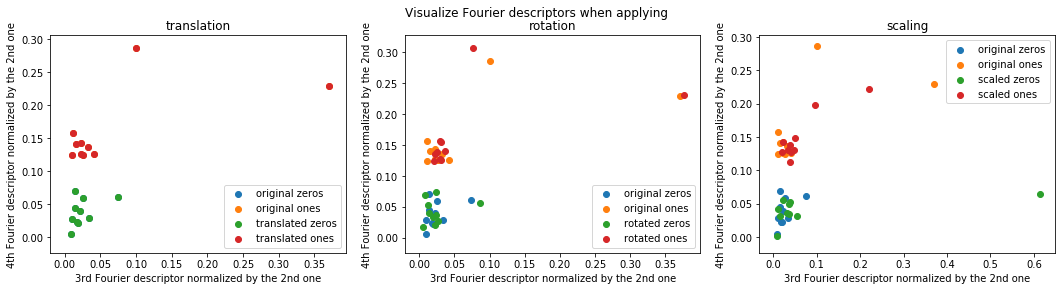

In [42]:
plot_2d_graph_with_transformation(
    compute_fourier_descriptors,
    zeros_im, ones_im,
    translated_zeros_im, translated_ones_im,
    rotated_zeros_im, rotated_ones_im,
    scaled_zeros_im, scaled_ones_im,
    'zeros', 'ones',
    xlabel='3rd Fourier descriptor normalized by the 2nd one',
    ylabel='4th Fourier descriptor normalized by the 2nd one'
)

### 1.3 Additional method(s)
Add your implementation and discussion

#### 1. Region-based descriptors (perimeter and area)

In [15]:
def compute_area_compacity(im):
    """Compute perimeter and area."""
    im = preprocessing(im)
    contour = find_contour(im)
    perimeter = contour.shape[0]
    contour = np.expand_dims(contour.astype(np.float32), 1)
    # Convert it to UMat object
    contour = cv.UMat(contour)
    area = cv.contourArea(contour)
    compacity = perimeter ** 2 / area
    return np.array([area, compacity])

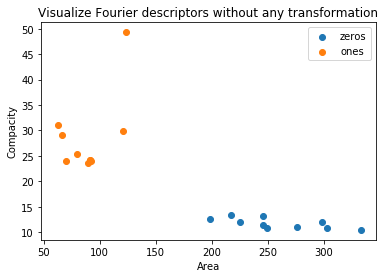

In [29]:
plot_2d_graph_without_transform(
    compute_area_compacity,
    zeros_im, ones_im,
    'zeros', 'ones',
    xlabel='Area',
    ylabel='Compacity'
)

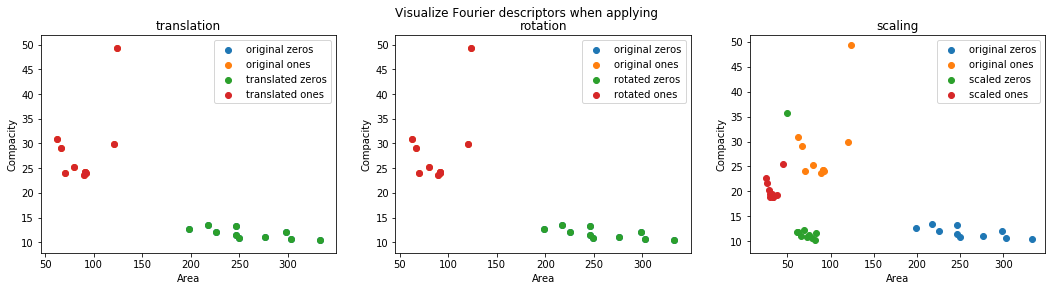

In [43]:
plot_2d_graph_with_transformation(
    compute_area_compacity,
    zeros_im, ones_im,
    translated_zeros_im, translated_ones_im,
    rotated_zeros_im, rotated_ones_im,
    scaled_zeros_im, scaled_ones_im,
    'zeros', 'ones',
    xlabel='Area',
    ylabel='Compacity'
)

#### 2. Region-based descriptors (rectangularity and elongation)

In [18]:
def compute_rectangularity_elongation(im):
    """Compute rectangularity and elongation."""
    im = preprocessing(im)
    contour = find_contour(im)
    perimeter = contour.shape[0]
    contour = np.expand_dims(contour.astype(np.float32), 1)
    # Convert it to UMat object
    contour = cv.UMat(contour)
    area = cv.contourArea(contour)
    xcoor, ycoor, width, height = cv.boundingRect(contour)
    rect_area = width * height
    rectangularity = float(area) / rect_area
    moments = cv.moments(contour)
    elongation = 2 * moments['mu11'] / (moments['mu20'] - moments['mu02'])
    return np.array([rectangularity, elongation])

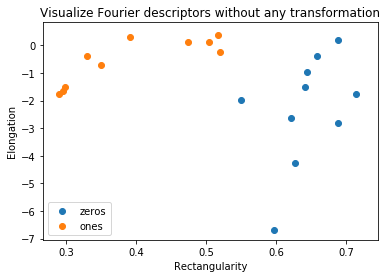

In [47]:
plot_2d_graph_without_transform(
    compute_rectangularity_elongation,
    zeros_im, ones_im,
    'zeros', 'ones',
    xlabel='Rectangularity',
    ylabel='Elongation'
)

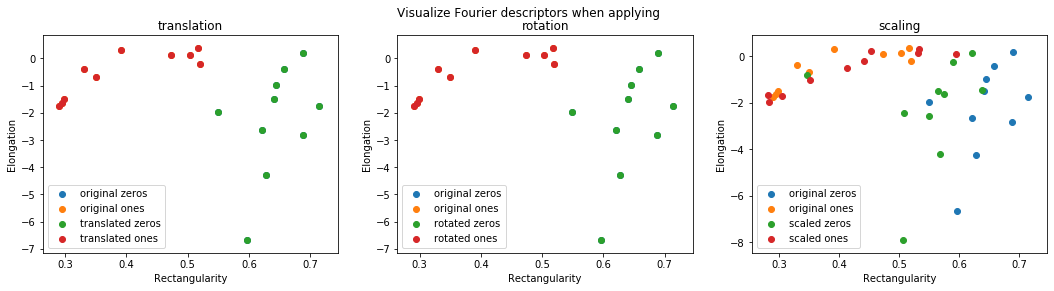

In [45]:
plot_2d_graph_with_transformation(
    compute_rectangularity_elongation,
    zeros_im, ones_im,
    translated_zeros_im, translated_ones_im,
    rotated_zeros_im, rotated_ones_im,
    scaled_zeros_im, scaled_ones_im,
    'zeros', 'ones',
    xlabel='Rectangularity',
    ylabel='Elongation'
)

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

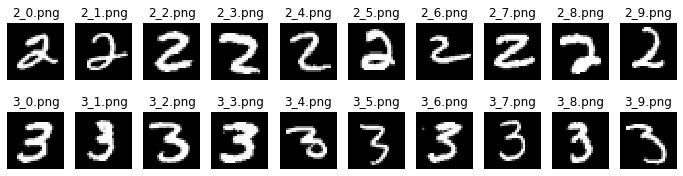

In [23]:
#  Load twos
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load threes
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

#### 1. Fourier Descriptors

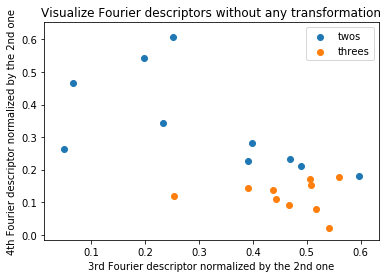

In [33]:
plot_2d_graph_without_transform(
    compute_fourier_descriptors,
    twos_im, threes_im,
    'twos', 'threes',
    xlabel='3rd Fourier descriptor normalized by the 2nd one',
    ylabel='4th Fourier descriptor normalized by the 2nd one'
)

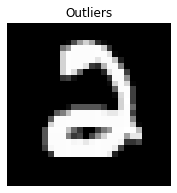

In [37]:
# check the outliers
twos_feat = np.array(list(map(compute_fourier_descriptors, twos_im)))
outliers = twos_im[twos_feat[:, 0] > 0.55]
plt.figure(figsize=(6, 3))
plt.title('Outliers')
plt.imshow(outliers[i], cmap='gray')
plt.axis('off')
plt.show()

In [38]:
# apply transformation
# translation
translation_transform = transform.AffineTransform(translation=(2, -2))
translated_twos_im = np.array(list(map(lambda im: transform.warp(im, translation_transform, preserve_range=True), twos_im)), dtype='uint8')
translated_threes_im = np.array(list(map(lambda im: transform.warp(im, translation_transform, preserve_range=True), threes_im)), dtype='uint8')
# rotation
rotated_twos_im = np.array(list(map(lambda im: transform.rotate(im, 90, order=5, preserve_range=True), twos_im)), dtype='uint8')
rotated_threes_im = np.array(list(map(lambda im: transform.rotate(im, 90, order=5, preserve_range=True), threes_im)), dtype='uint8')
# scaling
scaled_twos_im = np.array(list(map(lambda im: custom_rescale(im, 0.5), twos_im)), dtype='uint8')
scaled_threes_im = np.array(list(map(lambda im: custom_rescale(im, 0.5), threes_im)), dtype='uint8')

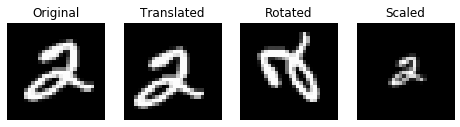

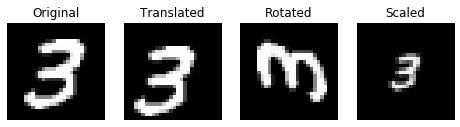

In [39]:
# show example images after the transformation
plot_name = ['Original', 'Translated', 'Rotated', 'Scaled']
all_twos_im = [twos_im, translated_twos_im, rotated_twos_im, scaled_twos_im]
all_threes_im = [threes_im, translated_threes_im, rotated_threes_im, scaled_threes_im]
fig, axes = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    axes[i].imshow(all_twos_im[i][0], cmap='gray')
    axes[i].set_title(plot_name[i])
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    axes[i].imshow(all_threes_im[i][0], cmap='gray')
    axes[i].set_title(plot_name[i])
    axes[i].axis('off')
plt.show()

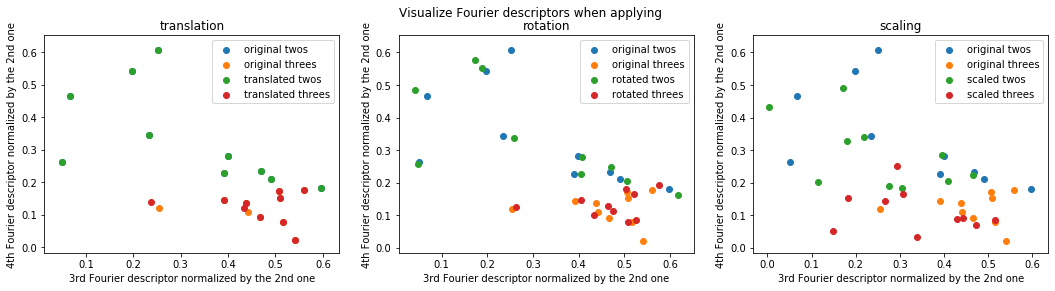

In [46]:
plot_2d_graph_with_transformation(
    compute_fourier_descriptors,
    twos_im, threes_im,
    translated_twos_im, translated_threes_im,
    rotated_twos_im, rotated_threes_im,
    scaled_twos_im, scaled_threes_im,
    'twos', 'threes',
    xlabel='3rd Fourier descriptor normalized by the 2nd one',
    ylabel='4th Fourier descriptor normalized by the 2nd one'
)

#### 2. Region-based descriptors (perimeter and area)

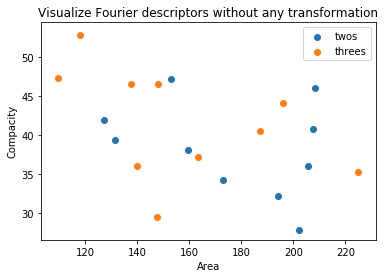

In [48]:
plot_2d_graph_without_transform(
    compute_area_compacity,
    twos_im, threes_im,
    'twos', 'threes',
    xlabel='Area',
    ylabel='Compacity'
)

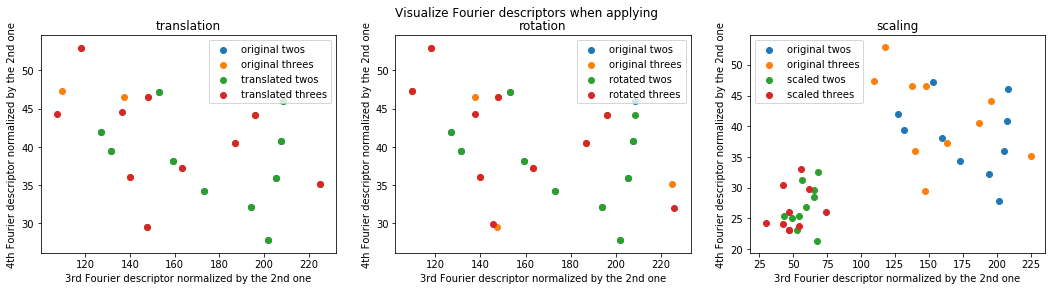

In [49]:
plot_2d_graph_with_transformation(
    compute_area_compacity,
    twos_im, threes_im,
    translated_twos_im, translated_threes_im,
    rotated_twos_im, rotated_threes_im,
    scaled_twos_im, scaled_threes_im,
    'twos', 'threes',
    xlabel='3rd Fourier descriptor normalized by the 2nd one',
    ylabel='4th Fourier descriptor normalized by the 2nd one'
)

#### 3. Region-based descriptors (rectangularity and elongation)

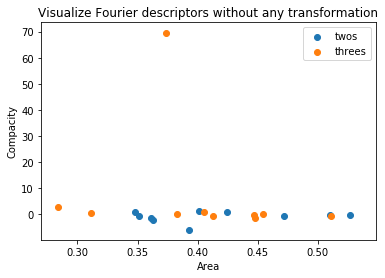

In [50]:
plot_2d_graph_without_transform(
    compute_rectangularity_elongation,
    twos_im, threes_im,
    'twos', 'threes',
    xlabel='Area',
    ylabel='Compacity'
)

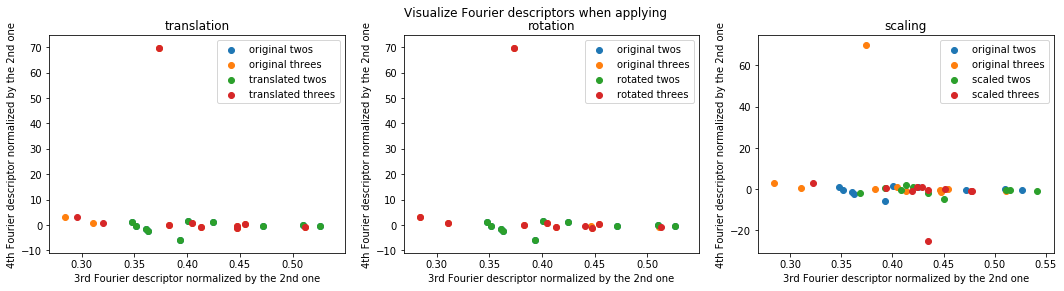

In [51]:
plot_2d_graph_with_transformation(
    compute_rectangularity_elongation,
    twos_im, threes_im,
    translated_twos_im, translated_threes_im,
    rotated_twos_im, rotated_threes_im,
    scaled_twos_im, scaled_threes_im,
    'twos', 'threes',
    xlabel='3rd Fourier descriptor normalized by the 2nd one',
    ylabel='4th Fourier descriptor normalized by the 2nd one'
)